# Skip-VAE
This notebook implements the Skip-VAE. It is trained and evaluated on the LGG Segmentation dataset from kaggle. 

This notebook includes the following:

- Firstly packeges and helper functions are imported.

- Dataloaders are defined using a helper loading functions from the scripts/data.py.

- The model is defined using pytorch and pyro to efficiently define model structure.

- A custom elbo is defined to help with KL annealing.

- The model is trained and evaluated using helper functions from scripts/funcs.py.

- Lastly, images, ground truths, and sample predictions is visualized.

In [ ]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
import torch.nn.functional as F
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from pyro import poutine
from torch import nn

import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

# --- Import Custom Modules ---
from scripts.data import get_loaders
from scripts.funcs import run_model, print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

### Define Dataloaders

In [83]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Model

In [ ]:
# Define convolutional block
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Encoder with skip connections
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = double_conv(3, 128)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = double_conv(128, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = double_conv(64, 32)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = double_conv(32, 16)
        self.pool4 = nn.MaxPool2d(2)

        self.enc5 = double_conv(16, 8)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        x5 = self.enc5(self.pool4(x4))
        return x1, x2, x3, x4, x5

# VAE bottleneck
class Bottleneck(nn.Module):
    def __init__(self, input_shape, z_dim=32):
        super().__init__()
        C, H, W = input_shape
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(C * H * W, z_dim)
        self.fc_logvar = nn.Linear(C * H * W, z_dim)
        self.fc_up = nn.Linear(z_dim, C * H * W)
        self.C, self.H, self.W = C, H, W

    def forward(self, x):
        x_flat = self.flatten(x)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_up = self.fc_up(z).view(-1, self.C, self.H, self.W)
        return x_up, mu, logvar

# Decoder with skip connections
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = double_conv(8 + 16, 16)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = double_conv(16 + 32 + 8, 32)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = double_conv(32 + 64 + 8, 64)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = double_conv(64 + 128 + 8, 128)

        self.out_conv = nn.Conv2d(128, 1, 1)

    def forward(self, z, skips):
        x4, x3, x2, x1 = skips
        # Stage 1
        x = self.up1(z)           
        z_up = self.up1(z)          # Upsample z (B,8,8,8)
        x = self.dec1(torch.cat([x4, z_up], dim=1))
        # Stage 2
        x = self.up2(x)
        z2 = self.up2(z_up)         # Upsample z (B,8,16,16)
        x = self.dec2(torch.cat([x, x3, z2], dim=1))
        # Stage 3
        x = self.up3(x)
        z3 = self.up3(z2)           # Upsample z (B,8,32,32)
        x = self.dec3(torch.cat([x, x2, z3], dim=1))
        # Stage 4
        x = self.up4(x)
        z4 = self.up4(z3)           # Upsample z (B,8,64,64)
        x = self.dec4(torch.cat([x, x1, z4], dim=1))
        return torch.sigmoid(self.out_conv(x))

# Full VAE with skip connections
class SkipVAE(nn.Module):
    def __init__(self, z_dim=32):
        super().__init__()
        self.encoder = Encoder()
        self.bottleneck = Bottleneck(input_shape=(8, 4, 4), z_dim=z_dim)
        self.decoder = Decoder()

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        z_up, mu, logvar = self.bottleneck(x5)
        recon = self.decoder(z_up, skips=[x4, x3, x2, x1])
        return recon, mu, logvar

### Define Skip-VAE

In [ ]:
# --- Define VAE ---
class SKIPVAE(nn.Module):
    def __init__(self, z_dim=32, input_dim=IMG_SIZE * IMG_SIZE * 3):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE
        self.z_dim = z_dim

        self.encoder = Encoder()
        self.bottleneck = Bottleneck(input_shape=(8, 4, 4), z_dim=z_dim)
        self.decoder = Decoder()

    # p(y | z) p(z)
    def model(self, x, y=None):
        pyro.module("encoder", self.encoder)
        pyro.module("decoder", self.decoder)
        pyro.module("bottleneck", self.bottleneck)

        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            # prior p(z)
            z_loc = torch.zeros(batch_size, self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(batch_size, self.z_dim, dtype=x.dtype, device=x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # get skip features from encoder
            x1, x2, x3, x4, _ = self.encoder(x)

            # manually decode (no bottleneck here)
            z_up = self.bottleneck.fc_up(z).view(batch_size, 8, 4, 4)
            yhat = self.decoder(z_up, skips=[x4, x3, x2, x1])

            if y is not None:
                pyro.sample("obs", dist.Bernoulli(yhat, validate_args=False).to_event(3), obs=y)
            else:
                pyro.deterministic('obs', yhat.detach())

            return yhat

    # q(z | x)
    def guide(self, x, y=None):
        pyro.module("encoder", self.encoder)
        pyro.module("bottleneck", self.bottleneck)

        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            # encode + get latent dist
            _, _, _, _, x5 = self.encoder(x)
            _, mu, logvar = self.bottleneck(x5)
            pyro.sample("latent", dist.Normal(mu, torch.exp(0.5 * logvar)).to_event(1))


### Test forward paas

In [ ]:
skipvae = SKIPVAE().to(device)
output = skipvae.model(torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device))
print(output.shape)

torch.Size([1, 1, 64, 64])


### Define the ELBO loss with KL annealing

In [ ]:
# --- Define KL Annealing Loss ---
def elbo_kl_annealing(model, guide, x, y=None, latents_to_anneal=["latent"], beta=1.0):
    # get the annealing factor and latents to anneal
    annealing_factor = beta
    latents_to_anneal = latents_to_anneal
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(
        guide).get_trace(x, y)
    
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x, y)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [ ]:
# --- Training the VAE ---
num_epochs = 300
test_frequency = 10
lr = 1e-4

skipvae = SKIPVAE(z_dim=24, input_dim=IMG_SIZE*IMG_SIZE*3)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(skipvae.model, skipvae.guide, optimizer, loss=elbo_kl_annealing)

skipvae = run_model(skipvae, svi, train_loader, test_loader, 
                num_epochs=num_epochs, warmup_epochs=20,
                test_frequency=test_frequency, device=device)

[Epoch 1]
Mean training elbo: 760.5486
Beta: 1.0000

[Epoch 2]
Mean training elbo: 207.8654
Beta: 1.0000

[Epoch 3]
Mean training elbo: 133.4671
Beta: 1.0000

[Epoch 4]
Mean training elbo: 102.7682
Beta: 1.0000

[Epoch 5]
Mean training elbo: 86.4013
Beta: 1.0000

[Epoch 6]
Mean training elbo: 79.1356
Beta: 1.0000

[Epoch 7]
Mean training elbo: 66.3311
Beta: 1.0000

[Epoch 8]
Mean training elbo: 60.9826
Beta: 1.0000

[Epoch 9]
Mean training elbo: 55.9693
Beta: 1.0000

[Epoch 10]
Mean training elbo: 52.8834
Beta: 1.0000
Mean test loss: 50.8422

[Epoch 11]
Mean training elbo: 50.6605
Beta: 1.0000

[Epoch 12]
Mean training elbo: 45.0744
Beta: 1.0000

[Epoch 13]
Mean training elbo: 43.6521
Beta: 1.0000

[Epoch 14]
Mean training elbo: 43.4671
Beta: 1.0000

[Epoch 15]
Mean training elbo: 43.6588
Beta: 1.0000

[Epoch 16]
Mean training elbo: 40.0228
Beta: 1.0000

[Epoch 17]
Mean training elbo: 41.5900
Beta: 1.0000

[Epoch 18]
Mean training elbo: 40.4224
Beta: 1.0000

[Epoch 19]
Mean training el

In [ ]:
# Model evaluation
def predict(x):
    posterior_predictive = Predictive(skipvae.model, guide=skipvae.guide, num_samples=1)
    pred = posterior_predictive(x)["obs"]
    return pred.squeeze(0)

skipvae.eval()
with torch.no_grad():
    print_losses(test_loader, skipvae, predict, device)

BCE loss:
0.01

Average DICE score:
0.86

ELBO loss:
37.25


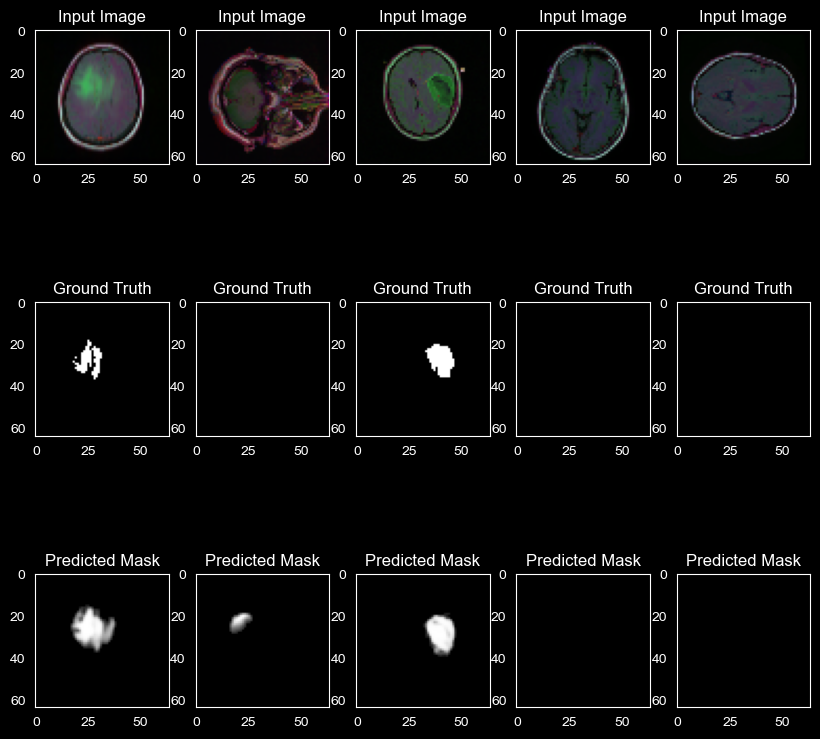

In [ ]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = predict(images)
        outputs[outputs < 0.1] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow((images[i].transpose(1, 2, 0)*std + mean).clip(0, 1))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(skipvae, test_loader)